In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
gDrivePath = "/content/drive/My Drive/Link prediction/"

In [ ]:
!pip install -q pymorphy2
!pip install -q bigartm10
!pip install -q catboost

     |████████████████████████████████| 61kB 2.5MB/s 
     |████████████████████████████████| 8.2MB 5.1MB/s 
     |████████████████████████████████| 2.0MB 2.8MB/s 
     |████████████████████████████████| 67.3MB 58kB/s 


In [ ]:
import pandas as pd
import pickle
import json, os, re
from tqdm import tqdm as tq
import pymorphy2
import artm
import numpy as np
from scipy import spatial
import networkx as nx
from itertools import combinations
import catboost as cgb
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot   as plt
from scipy import sparse
from sklearn.metrics import roc_auc_score, precision_score, balanced_accuracy_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from catboost.utils import get_roc_curve, select_threshold
from sklearn.metrics import balanced_accuracy_score, precision_recall_curve, auc, recall_score, f1_score, precision_score, classification_report

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


## Чистим текст

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def cleanNames(names_list):
    expr = r'[А-ЯЁ]\.[А-ЯЁ]\. [А-ЯЁ][а-яё]*|[А-ЯЁ][а-яё]* [А-ЯЁ]\.[А-ЯЁ]\.'
    filt_list = []
    for name in names_list:
        filt_list.append([x for x in re.findall(expr, name) if x != []])
    filt_list2 = []
    for l in flatten(filt_list):
        x1, x2 = l.split(' ')
        if x1.count('.') == 2:
            filt_list2.append(l)
        else:
            filt_list2.append(' '.join([x2,x1]))
    return filt_list2

In [ ]:
json_files = os.listdir(gDrivePath + "geofix/")
json_files.sort()
df = pd.DataFrame(columns=['authors_raw', 'year', 'geo', 'geo_full', 'text'])

for index, js in enumerate(json_files):
    with open(os.path.join(gDrivePath + "geofix/", js)) as json_file:
        json_text = json.load(json_file)
        authors = json_text['authors_cleaned']
        year = json_text['year']
        geo = json_text['geo_tags']
        geo_full = json_text['geo_tags_full']
        text = json_text['text']
        df.loc[index] = [authors, year, geo, geo_full, text]

In [ ]:
df['authors'] = df['authors_raw'].apply(cleanNames)
df['year'] = df['year'].astype(int)
df.head()

In [ ]:
df = pd.read_csv(gDrivePath + 'initial_data_2015.csv')
df.updated_geo = df.updated_geo.apply(eval)
df.geo_full = df.geo_full.apply(eval)
#df.to_csv(gDrivePath + 'initial_data.csv')
#df.to_csv(gDrivePath + 'initial_data_2015.csv')

In [ ]:
F = pd.read_csv(gDrivePath + 'F_2015.csv')

In [ ]:
df[df.year==2016].shape

(302, 8)

In [ ]:
from collections import Counter

def set_geos(geos):
  all_geos = geos.items()
  authors = list(geos.keys())
  geo_to_count = Counter([geo[1] for geo in all_geos if isinstance(geo[1], str)])
  if len(geo_to_count) == 0:
    for author in authors:
      geos[author] = ''
    return geos
  frequent_geo = max(geo_to_count.items(), key = lambda kvp: kvp[1])[0]
  for author in authors:
    if not isinstance(geos[author], str):
      geos[author] = frequent_geo
  return geos

df['updated_geo'] = df.geo_full.apply(set_geos)

In [ ]:
def remove_useless(row):
  text = row['text']
  index = row['index']
  kw_index_en = text.find("Key words")
  kw_index_ru = text.find("Ключевые слова")
  email_index = text.find("E-mail")
  reference_index_en = text.find("Reference")
  reference_index_ru = text.find("Спиоск литературы")
  begin = 0
  if kw_index_en > kw_index_ru:
    begin = kw_index_en + len("key words")
  elif kw_index_en < kw_index_ru:
    begin = kw_index_ru + len("Ключевые слова")
  end = len(text)
  if reference_index_en < reference_index_ru:
    end = reference_index_en
  else:
    end = reference_index_ru
  center = text[begin:end]
  words = [morph.parse(x.lower().replace(u'ё', u'е'))[0].normal_form
           for x in re.findall(r'[ЁА-Яа-яё]+', center)
           if len(x) > 2 and x != "при" and x != "для" and x != "быть" and x != "что" and x != "рис" and x != 'это' and x != 'где']
  return str(index) + " |words " + " ".join(words)

In [ ]:
morph = pymorphy2.MorphAnalyzer()
vw = df.reset_index().apply(remove_useless, axis=1)
vw.head(3)

/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


0    0 |words надёжность трубопровод прочность расч...
1    1 |words высоковязкий тяжёлый нефть сложнопост...
2    2 |words ления тогурский свита как основной по...
dtype: object

In [ ]:
# with open(gDrivePath + 'vw_rp_2015.txt', 'w') as fout:
#     for line in vw:
#         fout.write(line + '\n')

# Строим тематические модели

In [ ]:
# batch_vectorizer = artm.BatchVectorizer(data_path=gDrivePath + 'vw_rp_2015.txt', data_format='vowpal_wabbit', collection_name='vw', target_folder=gDrivePath + 'batches_rp_2015')

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path=gDrivePath + 'batches_rp_2015', data_format = 'batches')

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary

artm.Dictionary(name=e9486bf5-c748-4157-839e-4bf3e9840727, num_entries=62841)

In [ ]:
def print_topic_top_words(model, metric):
    for topic_name in model.topic_names:
      print(topic_name + ': '),
      try:
          print(", ".join(model.score_tracker[metric].last_tokens[topic_name]))
      except:
          print("Not enough unigrams in a topic")
          print()

## PLSA

In [ ]:
model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(10)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       cache_theta=True, reuse_theta=True, theta_columns_naming='title')

In [ ]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScoreP', class_id='words', eps=1e-5))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScoreP', eps=1e-5))
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScoreP', num_tokens=10, class_id='words'))

In [ ]:
model_plsa.initialize(dictionary=dictionary)

In [ ]:
%%time
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

CPU times: user 1min 2s, sys: 1.12 s, total: 1min 3s
Wall time: 50 s


In [ ]:
print_topic_top_words(model_plsa, 'TopTokensScoreP')

topic_0: 
пласт, коллектор, порода, скважина, данные, исследование, керн, пористость, результат, проницаемость
topic_1: 
отложение, порода, значение, месторождение, углеводород, нефтяной, работа, зона, нефть, быть
topic_2: 
нефтяной, система, работа, исследование, использование, хозяйство, который, установка, применение, технология
topic_3: 
давление, нефть, газ, нефтяной, коэффициент, вода, значение, зависимость, расчёт, жидкость
topic_4: 
нефть, скважина, месторождение, разработка, пласт, нефтяной, добыча, запас, технология, вода
topic_5: 
нефть, раствор, состав, температура, вода, образец, нефтяной, содержание, порода, месторождение
topic_6: 
скважина, трещина, грп, давление, пласт, бурение, ствол, колонна, работа, жидкость
topic_7: 
модель, система, данные, решение, работа, оценка, расчёт, параметр, проект, объект
topic_8: 
нефтяной, нефть, оао, компания, быть, месторождение, работа, год, газ, который
topic_9: 
отложение, зона, порода, часть, разрез, западный, работа, свита, которы

In [ ]:
print(model_plsa.score_tracker['SparsityPhiScoreP'].last_value)
print(model_plsa.score_tracker['SparsityThetaScoreP'].last_value)
theta0 = model_plsa.get_theta()
print('Num zeros col in theta: ', sum([(theta0[i] == 0).all() for i in theta0.columns]))

0.903433620929718
0.5809407830238342
Num zeros col in theta:  0


In [ ]:
# F = model_plsa.get_theta()
# F.to_csv(gDrivePath+f'/data/plsa_theta.csv')

## LDA

In [ ]:
model_lda = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(14)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.7),
                                     artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1)],
                       cache_theta=True, reuse_theta=True, theta_columns_naming='title')

In [ ]:
model_lda.scores.add(artm.SparsityPhiScore(name='SparsityPhiScoreL', class_id='words', eps=1e-5))
model_lda.scores.add(artm.SparsityThetaScore(name='SparsityThetaScoreL', eps=1e-5))
model_lda.scores.add(artm.TopTokensScore(name='TopTokensScoreL', num_tokens=15, class_id='words'))
model_lda.initialize(dictionary=dictionary)

In [ ]:
%%time
model_lda.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

CPU times: user 1min 13s, sys: 1.27 s, total: 1min 14s
Wall time: 59.6 s


In [ ]:
print(model_lda.score_tracker['SparsityPhiScoreL'].last_value)
print(model_lda.score_tracker['SparsityThetaScoreL'].last_value)
theta0 = model_lda.get_theta()
print('Num zeros col in theta: ', sum([(theta0[i] == 0).all() for i in theta0.columns]))

0.9135684967041016
0.6130807399749756
Num zeros col in theta:  0


In [ ]:
print_topic_top_words(model_lda, 'TopTokensScoreL')

In [ ]:
# F = model_lda.get_theta()
# F.to_csv(gDrivePath+'/data/lda_theta.csv')

## ARTM

In [ ]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(9)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5),
                                     artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.001)],
                       cache_theta=True, reuse_theta=True, theta_columns_naming='title')

In [ ]:
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=-50e3))

In [ ]:
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScoreA', class_id='words', eps=1e-5))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScoreA', eps=1e-5))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScoreA', num_tokens=15, class_id='words'))

In [ ]:
model_artm.initialize(dictionary=dictionary)

In [ ]:
%%time
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

KeyboardInterrupt: ignored

In [ ]:
print(model_artm.score_tracker['SparsityPhiScoreA'].last_value)
print(model_artm.score_tracker['SparsityThetaScoreA'].last_value)
theta0 = model_artm.get_theta()
print('Num zeros col in theta: ', sum([(theta0[i] == 0).all() for i in theta0.columns]))

In [ ]:
print_topic_top_words(model_artm, 'TopTokensScoreA')

In [ ]:
F = model_artm.get_theta()
# F.to_csv(gDrivePath+f'/data/artm_theta.csv')

## Иерархическая

In [ ]:
hier = artm.hARTM(scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary)],
                  cache_theta=True, reuse_theta=True, theta_columns_naming='title')

In [ ]:
level0 = hier.add_level(num_topics=9)
level0.initialize(dictionary)
level0.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi0', tau=5e3))
level0.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
level0.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))

level0.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore0', class_id='words', eps=1e-5))
level0.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore0', eps=1e-5))
%time level0.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 32.3 s, sys: 476 ms, total: 32.8 s
Wall time: 23 s


In [ ]:
print('level0')
print('SparsityPhi: ', level0.score_tracker['SparsityPhiScore0'].last_value)
print('SparsityTheta: ', level0.score_tracker['SparsityThetaScore0'].last_value)
theta0 = level0.get_theta()
print('Num zeros col in theta: ', sum([(theta0[i] == 0).all() for i in theta0.columns]))

level0
SparsityPhi:  0.9107341170310974
SparsityTheta:  0.49851495027542114
Num zeros col in theta:  0


In [ ]:
level1 = hier.add_level(num_topics=50, topic_names=['child_topic_' + str(i) for i in range(25)], parent_level_weight=1)
level1.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore1', class_id='words', eps=1e-5))
level1.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore1', eps=1e-5))
level1.scores.add(artm.TopTokensScore(name='TopTokensScore1', num_tokens=15, class_id='words'))
level1.regularizers.add(artm.HierarchySparsingThetaRegularizer(name="HierSp", tau=2),overwrite=True)
level1.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),overwrite=True)

In [ ]:
level1.initialize(dictionary)
level1.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.01),overwrite=True)
level1.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi1', tau=15e4),overwrite=True)
%time level1.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 54.2 s, sys: 813 ms, total: 55 s
Wall time: 35.8 s


In [ ]:
print('level1')
print('SparsityPhi: ', level1.score_tracker['SparsityPhiScore1'].last_value)
print('SparsityTheta: ', level1.score_tracker['SparsityThetaScore1'].last_value)
theta1 = level1.get_theta()
print('Num zeros col in theta: ',sum([(theta1[i] == 0).all() for i in theta1.columns]))

level1
SparsityPhi:  0.9150694608688354
SparsityTheta:  0.6169210076332092
Num zeros col in theta:  0


In [ ]:
print_topic_top_words(level1, 'TopTokensScore1')

child_topic_0: 
модель, нефть, значение, данные, результат, пласт, нефтяной, разработка, параметр, быть, получить, вытеснение, моделирование, зависимость, метод
child_topic_1: 
образец, порода, керн, исследование, вода, зависимость, метод, проницаемость, коэффициент, поровый, скорость, значение, измерение, нефтяной, параметр
child_topic_2: 
газ, энергия, сепаратор, поток, нефтяной, ротор, процесс, мощность, частота, сепарация, использование, нефтепровод, нефть, турбина, где
child_topic_3: 
коррозия, трубопровод, коррозионный, защита, ингибитор, сеть, система, битум, среда, испытание, кислотный, время, год, обработка, фотография
child_topic_4: 
год, нефть, разработка, оао, быть, страна, кислота, млн, новый, который, компания, сша, реагент, нефтегазовый, институт
child_topic_5: 
содержание, отложение, территория, вещество, органический, толща, южный, генерация, условие, бассейн, оценка, район, впадина, нефтяной, зона
child_topic_6: 
давление, скважина, трещина, пласт, разработка, месторо

## Визуализатор

In [ ]:
theta_T = level1.get_theta().T
phi_T = level1.get_phi().T
phi_T.columns = phi_T.columns.to_series().apply(lambda name: name[1])
phi_T.head()

,нерезультативный,документироваться,мотивационный,действенность,перениматься,институционализация,риваля,союзнефтеотдача,щелкачев,универсиитат,шоболово,анссср,жигач,краковский,надя,фосфатокремнистый,гиммельфарбский,электродрель,шлифовать,колпачок,стеклянрация,прудить,безрис,упереться,дубна,мантсгео,катор,батскома,пго,уинский,ангасякнуть,василовский,кереметовый,недеспергировать,довытеснять,гированная,недиспер,ромм,полутоновый,брокеридж,...,новаторство,следовано,термобурение,чугорьяхинский,ааний,парус,типоразмерный,ипполитовский,исследопараметр,тимкий,шпицберген,апрельмать,сдуваться,голофаста,расщелина,пилообразность,малообеспеченный,тёртый,бравичев,агодарность,клячкина,ярославцев,предпоказатель,канапый,торошение,сэлида,барсуковдлить,оставот,преимущпптч,отобранлять,улучшаться,месторождефициент,керногост,внутхимически,ефимец,долговременный,посредством,мегафациальный,титаномагнетит,ильменит
child_topic_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000006,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000006,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000002,0.0,0.0,0.0,0.0,0.000036,0.0,0.0,0.0,0.0,5.492411e-07,0.000046,0.0,0.0,0.0
child_topic_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000014,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000017,0.0,0.000017,0.000000,0.0,0.000017,0.000000,0.0,0.0,0.0,0.0,0.000043,0.0,0.0,0.0,0.0,0.000000e+00,0.000017,0.0,0.0,0.0
child_topic_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000054,0.0,0.0,0.0,0.0,0.000000e+00,0.000061,0.0,0.0,0.0
child_topic_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000054,0.0,0.0,0.0,0.0,0.000000e+00,0.000003,0.0,0.0,0.0
child_topic_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000016,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000016,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000016,0.0,0.000033,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000008,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000007,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.000000e+00,0.000021,0.0,0.0,0.0


In [ ]:
!pip install -q pyldavis
import pyLDAvis

     |████████████████████████████████| 1.7MB 20.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3MB 211kB/s 
     |████████████████████████████████| 9.9MB 50.2MB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
doc_lengths = []
with open(gDrivePath + 'vw_rp_2015.txt', 'r') as file:
    for i in range(1459):
        words = file.readline().split()[2:]
        doc_lengths.append(len(words))

In [ ]:
html = pyLDAvis.prepare(topic_term_dists = phi_T.values, 
                        doc_topic_dists = theta_T.values, 
                        doc_lengths = doc_lengths,
                        vocab = phi_T.columns,
                        term_frequency = dictionary._master.get_dictionary(dictionary._name).token_tf,
                        R = 15)

pyLDAvis.save_html(html, 'hARTM.html')

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:235: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("topic_given_term.T / topic_proportion"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:258: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(pd.eval("topic_term_dists")).astype("float64")


In [ ]:
F = level1.get_theta()
F.to_csv(gDrivePath + 'F_2015.csv', index=False)
F.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458
child_topic_0,0.134406,0.204902,0.045138,0.064067,0.084834,0.000000,0.018568,0.249968,0.0,0.00000,0.000000,0.000000,0.000000,0.064552,0.367752,0.000000,0.000000,0.125279,0.22238,0.145606,0.06948,0.000000,0.202819,0.267235,0.000000,0.000000,0.184371,0.0,0.117757,0.0,0.0,0.000000,0.247175,0.000000,0.189715,0.0,0.007330,0.155371,0.416560,0.000000,...,0.000000,0.023698,0.096062,0.0,0.000296,0.002725,0.053124,0.000000,0.075344,0.412305,0.000000,0.479758,0.000044,0.000000,0.0,0.001240,0.006598,0.000000,0.0,0.155748,0.0,0.000193,0.000000,0.110614,0.198281,0.084979,0.0,0.446223,0.000000,0.528358,0.0,0.016148,0.0,0.000000,0.258498,0.009515,0.0,0.250976,0.000000,0.154698
child_topic_1,0.000327,0.000000,0.000000,0.000000,0.006622,0.008659,0.000000,0.000000,0.0,0.00000,0.003041,0.000000,0.000000,0.047457,0.035524,0.082453,0.000000,0.030145,0.00000,0.004926,0.00000,0.000000,0.000000,0.000000,0.002398,0.033209,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.007542,0.195646,0.013288,0.0,0.189715,0.000000,0.067771,0.000000,...,0.000000,0.000000,0.000000,0.0,0.190584,0.000000,0.001319,0.021922,0.000471,0.000706,0.147675,0.000000,0.004122,0.000000,0.0,0.012063,0.000000,0.000000,0.0,0.124950,0.0,0.000000,0.000000,0.000000,0.090529,0.070760,0.0,0.000000,0.000000,0.078979,0.0,0.126049,0.0,0.002462,0.004701,0.215787,0.0,0.000000,0.018337,0.071560
child_topic_2,0.000000,0.000000,0.000000,0.000000,0.084650,0.000000,0.000000,0.000000,0.0,0.16295,0.004271,0.000000,0.000000,0.000000,0.000000,0.018093,0.000000,0.007220,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000643,0.0,0.0,0.006206,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.245277,0.000000,0.000000,0.0,0.000000,0.000000,0.020182,0.008210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000262,0.000000,0.000000,0.000000,0.0,0.000000,0.494355,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.006138,0.000000
child_topic_3,0.087949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.429327,0.000000,0.000000,0.000000,0.000000,0.056108,0.005256,0.000000,0.00000,0.000000,0.00000,0.019349,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.007322,0.000106,0.0,0.000000,0.000000,0.000000,0.001308,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000408,0.000000,0.000000,0.000128,0.0,0.000000,0.000000,0.038816,0.0,0.000000,0.0,0.000000,0.000000,0.000306,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.004093,0.0,0.000000,0.000000,0.000000
child_topic_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.003048,0.000000,0.000000,0.0,0.00000,0.000000,0.005777,0.004404,0.000000,0.000000,0.022946,0.076088,0.000000,0.00000,0.033495,0.00000,0.010543,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.052317,0.0,0.0,0.052001,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.615114,...,0.000000,0.000000,0.000000,0.0,0.025542,0.004436,0.001532,0.000000,0.011946,0.001032,0.031119,0.000000,0.177563,0.042746,0.0,0.000000,0.062161,0.001522,0.0,0.000000,0.0,0.264603,0.207561,0.000000,0.000000,0.024908,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000913


In [ ]:
# theta0.to_csv(gDrivePath+'/data/hier_theta_0.csv')
# theta1.to_csv(gDrivePath+'/data/hier_theta_1.csv')
# psi = level1.get_psi()
# psi.to_csv(gDrivePath+'/data/hier_psi_1.csv')

In [ ]:
# with open(gDrivePath+'/data/phi1.batch', 'w') as f:
#     f.write('phi1.batch')

3143

# Авторы

In [ ]:
def normalize_geo(geo):
  geo = re.sub(r'[%s]' % re.escape(r"""!"#$%&'()*+,-./:;<=>?@[\]^_«»“”’*…/_.\\`{|}~"""), '', geo).strip()
  words = geo.split()
  if len(words) == 0:
    return ""
  if words[0] == "Institute":
    return " ".join(words[:3])
  elif words[0] == "et" or words[0] == "at":
    return ""
  else:
    return " ".join(words[:2])

In [ ]:
def create_graph(frame):
    G = nx.Graph()
    for i, row in frame.iterrows():
        authors = list(row['updated_geo'].items())
        if len(authors) == 1:
            try:
              geo = normalize_geo(authors[0][1])
            except AttributeError:
              geo = ''
            G.add_node(authors[0][0], geo = geo)
        else:
            for auth1, auth2 in combinations(authors, 2):
                try:
                    geo1 = normalize_geo(auth1[1])
                except AttributeError:
                    geo1 = ''
                try:
                    geo2 = normalize_geo(auth2[1])
                except AttributeError:
                    geo2 = ''
                    
                G.add_node(auth1[0], geo=geo1)
                G.add_node(auth2[0], geo=geo2)
                G.add_edge(auth1[0], auth2[0])
    return G

In [ ]:
paper_to_authors = df.geo_full.apply(lambda geos: list(geos.keys())).to_dict()
unique_authors = []
for authors in df.geo_full.apply(lambda geos: geos.keys()).tolist():
  unique_authors += authors
unique_authors = list(set(unique_authors))
author_to_papers = dict.fromkeys(unique_authors)

In [ ]:
for paper in F.columns:
  for author in paper_to_authors[int(paper)]:
    if author_to_papers[author] is None:
      author_to_papers[author] = [F[paper].tolist()]
    else:
      author_to_papers[author].append(F[paper].tolist())
for author in author_to_papers.keys():
  author_to_papers[author] = np.array(author_to_papers[author])

In [ ]:
author_to_vec = dict()
for author in author_to_papers.keys():
  author_to_vec[author] = np.mean(author_to_papers[author], axis = 0)

In [ ]:
def S(u_vec, v_vec):
  return 1 / np.exp(spatial.distance.cosine(u_vec, v_vec))

In [ ]:
def SIM(u_name, v_name, G, F):
  s = S(author_to_vec[u_name], author_to_vec[v_name])
  neighbors = nx.common_neighbors(G, u_name, v_name)
  norm = 0
  sum = 0
  for neighbor in neighbors:
    norm += 1
    uz_papers = np.array([F[str(paper)] for paper in paper_to_authors.keys()
                    if neighbor in paper_to_authors[paper]
                    and u_name in paper_to_authors[paper]])
    vz_papers = np.array([F[str(paper)] for paper in paper_to_authors.keys()
                    if neighbor in paper_to_authors[paper]
                    and v_name in paper_to_authors[paper]])
    x_uz = np.mean(uz_papers, axis=0)
    x_vz = np.mean(vz_papers, axis=0)
    sum += S(x_uz, x_vz)
  if sum == 0:
    return s
  else:
    return s / norm * sum

In [ ]:
def add_sim(G, F):
  for (u, v) in G.edges():
    G.add_edge(u, v, sim = SIM(u, v, G, F))
  return G

In [ ]:
df.updated_geo.head()

0    {'d.g. nerodenko': 'Tyumen State Oil and Gas U...
1            {'n.n. ivantsov': 'TNNC LLC, RF, Tyumen'}
2    {'i.v. goncharov': 'TomskNIPIneft JSC, RF, Tom...
3    {'v.yu. ovechkina': 'Paradigm, RF, Moscow', 't...
4    {'d.v. efimov': 'BashNIPIneft LLC, RF, Ufa', '...
Name: updated_geo, dtype: object

In [ ]:
with open(gDrivePath+'a2t.pickle', 'wb') as f:
  pickle.dump(dict([(k, np.argmax(v)) for (k, v) in author_to_vec.items()]), f)

# Train test split

In [ ]:
def get_geos_encode(df):
  updated_geos = df.updated_geo
  unique_geos = []
  for geos in updated_geos:
    for geo in geos.items():
      unique_geos.append(normalize_geo(geo[1]))
  unique_geos = list(set(unique_geos))
  i = 0
  geos_encode = {}
  for geo in unique_geos:
    geos_encode[geo] = i
    i += 1
  return geos_encode

In [ ]:
G_train = create_graph(df[(df.year >= 2012) & (df.year < 2016)])
G_val = create_graph(df[df.year == 2016])
G_test = create_graph(df[df.year == 2017])
common_authors_val = set(G_train.nodes).intersection(set(G_val.nodes))
common_authors_test = set(G_train.nodes).intersection(set(G_test.nodes))

In [ ]:
geos_encode = get_geos_encode(df)

def get_data(df, F, geos_encode):
  data = []
  G = add_sim(create_graph(df), F)
  for u, v in combinations(G.nodes(), 2):
    if G.has_edge(u, v):
      data.append([u, v, geos_encode[G.nodes[u]['geo']], geos_encode[G.nodes[v]['geo']], G[u][v]['sim'], 1])
    else:
      data.append([u, v, geos_encode[G.nodes[u]['geo']], geos_encode[G.nodes[v]['geo']], SIM(u, v, G, F), 0])
  return pd.DataFrame(data, columns=['author_1', 'author_2', 'author_1_a', 'author_2_a',  'sim', 'label'])

train_data = get_data(df[df.year < 2016], F, geos_encode)
val_data = get_data(df[df.year == 2016], F, geos_encode)
test_data = get_data(df[df.year == 2017], F, geos_encode)

In [ ]:
def get_data_without_aff(df, F):
  data = []
  G = add_sim(create_graph(df), F)
  for u, v in combinations(G.nodes(), 2):
    if G.has_edge(u, v):
      data.append([u, v, G.nodes[u]['geo']==G.nodes[v]['geo'], G[u][v]['sim'], 1])
    else:
      data.append([u, v, G.nodes[u]['geo']==G.nodes[v]['geo'], SIM(u, v, G, F), 0])
  return pd.DataFrame(data, columns=['author_1', 'author_2', 'same_a',  'sim', 'label'])

In [ ]:
def get_data_with_n_count(df, F):
  data = []
  G = add_sim(create_graph(df), F)
  for u, v in combinations(G.nodes(), 2):
    if G.has_edge(u, v):
      data.append([u, v, int(G.nodes[u]['geo']==G.nodes[v]['geo']), len(list(nx.common_neighbors(G, u, v))), G[u][v]['sim'], 1])
    else:
      data.append([u, v, int(G.nodes[u]['geo']==G.nodes[v]['geo']), len(list(nx.common_neighbors(G, u, v))), SIM(u, v, G, F), 0])
  return pd.DataFrame(data, columns=['author_1', 'author_2', 'same_a', 'cn',  'sim', 'label'])

In [ ]:
train_data = get_data_with_n_count(df[df.year < 2016], F)
val_data = get_data_with_n_count(df[df.year == 2016], F)
test_data = get_data_with_n_count(df[df.year == 2017], F)

,author_1,author_2,same_a,cn,sim,label
0,d.g. nerodenko,k.v. syzrantseva,1,0,0.721159,1
1,d.g. nerodenko,n.n. ivantsov,0,0,0.668037,0
2,d.g. nerodenko,i.v. goncharov,0,0,0.385511,0
3,d.g. nerodenko,n.v. oblasov,0,0,0.380196,0
4,d.g. nerodenko,a.v. smetanin,0,0,0.455621,0


In [ ]:
train_data.to_csv(gDrivePath + 'train_with_n.csv')
val_data.to_csv(gDrivePath + 'val_with_n.csv')
test_data.to_csv(gDrivePath + 'test_with_n.csv')

In [ ]:
#train_data_a = get_data_without_aff(df[df.year < 2016], F)
#val_data_a = get_data_without_aff(df[df.year == 2016], F)
#test_data_a = get_data_without_aff(df[df.year == 2017], F)
#test_data_a = test_data_a[test_data_a.author_1.isin(common_authors_test) & test_data_a.author_2.isin(common_authors_test)]
#val_data_a = val_data_a[val_data_a.author_1.isin(common_authors_val) & val_data_a.author_2.isin(common_authors_val)]
train_data = pd.read_csv(gDrivePath + 'train_a.csv')
test_data = pd.read_csv(gDrivePath + 'test_a.csv')
val_data = pd.read_csv(gDrivePath + 'val_a.csv')
print(test_data.shape, val_data.shape, train_data.shape)

(56280, 5) (66066, 5) (2355535, 5)


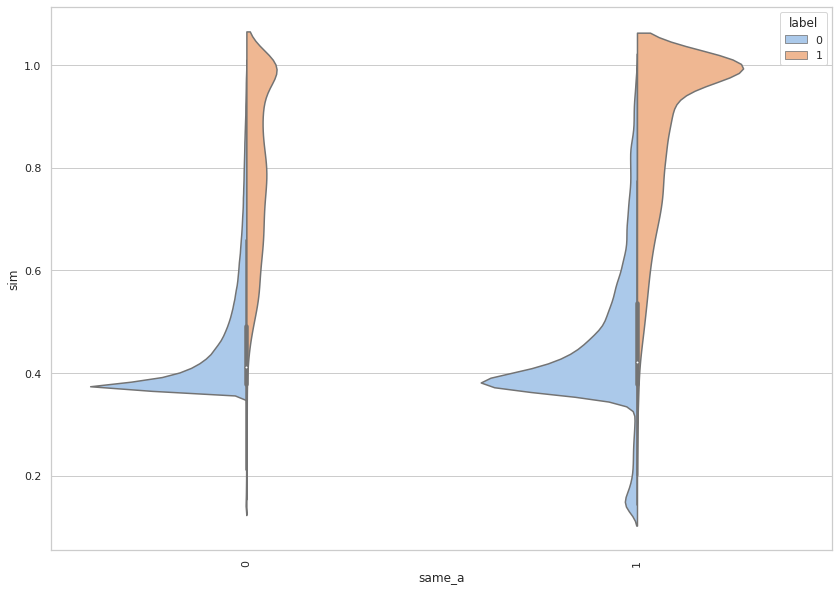

In [ ]:
import seaborn as sns
train_data_a['dummy'] = 0
plt.figure(figsize=(14, 10))
plt.xticks(rotation = 90)
sns.violinplot(y="sim", x="same_a", hue="label", data=train_data_a, palette="pastel", split=True)

In [ ]:
# train_data_a.to_csv(gDrivePath + 'train_a.csv', index=False)
# test_data_a.to_csv(gDrivePath + 'test_a.csv', index=False)
# val_data_a.to_csv(gDrivePath + 'val_a.csv', index=False)

In [ ]:
test_data = test_data[test_data.author_1.isin(common_authors_test) & test_data.author_2.isin(common_authors_test)]
val_data = val_data[val_data.author_1.isin(common_authors_val) & val_data.author_2.isin(common_authors_val)]
print(test_data.shape, val_data.shape, train_data.shape)

(56280, 5) (66066, 5) (2355535, 5)


In [ ]:
train_data.to_csv(gDrivePath + 'train.csv', index=False)
test_data.to_csv(gDrivePath + 'test.csv', index=False)
val_data.to_csv(gDrivePath + 'val.csv', index=False)

In [ ]:
train_data = pd.read_csv(gDrivePath + 'train_a.csv')
test_data = pd.read_csv(gDrivePath + 'test_a.csv')
val_data = pd.read_csv(gDrivePath + 'val_a.csv')

In [ ]:
test_data.shape

(56280, 5)

# Treshold method

In [ ]:
def calculateSim(G, F):
  n = G.number_of_nodes()
  d = sparse.lil_matrix((n, n), dtype=float)
  for i1, n1 in enumerate(G.nodes):
        for i2, n2 in enumerate(G.nodes):
            if n1 != n2:
                d[i2,i1] = SIM(n1, n2, G, F)
  return d

In [ ]:
sims = calculateSim(G_train, F)
df_train_sim = pd.DataFrame(sims.todense(), columns=G_train.nodes, index=G_train.nodes)
df_train_sim_ca = df_train_sim.loc[common_authors_val, common_authors_val]

In [ ]:
#матрица смежности для тестового набора
test_adj = nx.adjacency_matrix(G_val).todense()
# то же, только с именами
df_test_adj = pd.DataFrame(test_adj, columns=G_val.nodes, index=G_val.nodes)
# то же, только для авторов из обоих наборов (train - test)
df_test_adj_ca = df_test_adj.loc[common_authors_val, common_authors_val]

In [ ]:
#матрица смежности для тестового набора
test_adj = nx.adjacency_matrix(G_test).todense()
# то же, только с именами
df_test_adj = pd.DataFrame(test_adj, columns=G_test.nodes, index=G_test.nodes)
# то же, только для авторов из обоих наборов (train - test)
df_test_adj_ca = df_test_adj.loc[common_authors_test, common_authors_test]
df_train_sim_ca = df_train_sim.loc[common_authors_test, common_authors_test]

In [ ]:
#Сколько должно быть общих соседей чтобы сказать что между вершинами будет связь?
threshold = 0.791
#Матрица смежности для связей которые могут быть в будущем
mask = (df_train_sim_ca > threshold).astype(int)
#сколько ребер предсказано верно

#точность предсказания связей графа
precision = precision_score(df_test_adj_ca.values.flatten(), mask.values.flatten())
recall = recall_score(df_test_adj_ca.values.flatten(), mask.values.flatten())
f3 = 10 * recall * precision / (9 * precision + recall)
print('Precision ' + str(precision))
print('Recall ' + str(recall))
print('F3 ' + str(f3))

Precision 0.13811007268951195
Recall 0.5076335877862596
F3 0.40048178259560374


# TM + affiliations

In [ ]:
X_train = train_data.drop('author_1', axis=1).drop('author_2', axis=1).drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('author_1', axis=1).drop('author_2', axis=1).drop('label', axis=1)
y_test = test_data['label']
X_val = val_data.drop('author_1', axis=1).drop('author_2', axis=1).drop('label', axis=1)
y_val = val_data['label']
cat_feat = ['same_a']
test = cgb.Pool(data=X_test, label=y_test, cat_features=cat_feat)
val = cgb.Pool(data=X_val, label=y_val, cat_features=cat_feat)
train = cgb.Pool(data=X_train, label=y_train, cat_features=cat_feat)

In [ ]:
def score(params):
  model = cgb.CatBoostClassifier(**params, task_type="GPU", logging_level='Silent')
  model.fit(train, eval_set=val)
  metrics = model.eval_metrics(val, ['F1:use_weights=false'])

  return {'loss': -metrics['F1:use_weights=false'][-1], 'status': STATUS_OK}

space = {
    'loss_function': 'Logloss',
    'eval_metric': 'F1:use_weights=false',
    'iterations': hp.choice('iterations', np.arange(50, 500, 50)),
    'learning_rate': hp.uniform('learning_rate', 0.1, 1),
    'random_seed': 42,
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 20),
    'depth': hp.choice('depth', np.arange(3, 16, 1)),
    'min_data_in_leaf': hp.uniform('min_data_in_leaf', 0, 10),
    #'max_leaves': hp.choice('max_leaves', np.arange(20, 64, 1)),
    'auto_class_weights': hp.choice('auto_class_weights', ['Balanced', 'SqrtBalanced']),
          }

def optimize(trials, space):
  best = fmin(score, space, algo = tpe.suggest, max_evals = 400)
  return best

trials = Trials()
best_params = optimize(trials, space)

 12%|█▏        | 47/400 [14:36<1:49:44, 18.65s/it, best loss: -0.4305210918114144]


KeyboardInterrupt: ignored

# Классификатор (CatBoost)

In [ ]:
model = cgb.CatBoostClassifier(loss_function='Logloss',
                               eval_metric='F1:use_weights=false',
                               random_seed=42,
                               auto_class_weights='SqrtBalanced',
                               iterations = 70,
                               logging_level='Verbose')
model.fit(train, eval_set=val)

In [ ]:
def findBestTresholdForF1(probs, y):
  best_f1 = 0
  treshold = 0
  for prob in set(probs):
    preds = (probs > prob).astype(int)
    f1 = f1_score(y, preds)
    if f1 > best_f1:
      best_f1 = f1
      treshold = prob
  return best_f1, treshold

In [ ]:
probs = model.predict_proba(test)
f1, tresh = findBestTresholdForF1(probs[:, 1], test.get_label())
preds = (probs[:, 1] > tresh).astype(int)
f1

0.3784355179704017

In [ ]:
model.eval_metrics(test, ['PRAUC:use_weights=false', 'F1:use_weights=false', 'AUC:use_weights=false', 'Precision:use_weights=false', 'Recall:use_weights=false'])

In [ ]:
test.get_label().sum()

29127

In [ ]:
cgb.utils.get_confusion_matrix(model, test)

array([[  147.,   129.],
       [  724., 28403.]])

In [ ]:
metrics = model.eval_metrics(val, ['AUC', 'Precision', 'BalancedAccuracy'])

In [ ]:
def predict(model, train, test):
  roc_curve_values = get_roc_curve(model, train)
  boundary = select_threshold(model, curve=roc_curve_values, FPR=0.9)
  print(boundary)
  proba = model.predict_proba(test)
  predicted = (proba[:, 1] >  boundary).astype(int)
  return predicted, proba[:, 1]

predicted, proba = predict(model, train, val)

0.048717640047834763


In [ ]:
predicted = -1 * predicted + 1
actual = -1 * val.get_label() + 1
tp = (predicted * actual).sum()
print(roc_auc_score(actual, 1 - proba), tp / predicted.sum())
print(predicted.sum(), tp.sum())
print(actual.sum())

0.9116688423786579 0.7111111111111111
45 32
353


In [ ]:
plt.figure(figsize = (14,10))
plt.plot(np.arange(len(metrics['Precision'])), metrics['Precision'], label = 'Pr')
plt.plot(np.arange(len(metrics['AUC'])), metrics['AUC'], label = 'AUC')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize = (14,10))
plt.plot(np.arange(len(metrics['Precision'])), metrics['Precision'], label = 'Pr')
plt.plot(np.arange(len(metrics['AUC'])), metrics['AUC'], label = 'AUC')
plt.legend()
plt.grid(True)
plt.show()

# Classifier (Desision tree)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [ ]:
clf = DecisionTreeClassifier(random_state=42, class_weight = 'balanced')
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
train_data[train_data.label == 0].shape[0]

2349620

In [ ]:
probs = clf.predict_proba(X_test)
f1, tresh = findBestTresholdForF1(probs[:, 1], y_test)
preds = (probs[:, 1] > tresh).astype(int)
roc_auc_score(y_test, probs[:, 1])

0.6300640495200188

In [ ]:
classification_report(y_val, clf.predict(X_val), output_dict=True)['1']['f1-score']

0.3677342823250297

In [ ]:
def score(params):
  clf = DecisionTreeClassifier(random_state=42, class_weight = 'balanced')
  clf.fit(X_train, y_train)
  f1 = classification_report(y_val, clf.predict(X_val), output_dict=True)['1']['f1-score']
  return {'loss': -f1, 'status': STATUS_OK}

space = {
    'max_depth': hp.choice('max_depth', np.arange(3, 16, 1)),
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 5, 1)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 5, 1)),
    'max_features': hp.choice('max_features', [1, 2]),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', range(5, 64, 5)),
    'ccp_alpha': hp.uniform('ccp_alpha', 0, 10)
          }

def optimize(trials, space):
  best = fmin(score, space, algo = tpe.suggest, max_evals = 1000)
  return best

trials = Trials()
best_params = optimize(trials, space)